# Size of images  at USDF 

In [2]:
# This cell is only for setting parameter defaults
day = "20260104"
instrument = 'LSSTCam'

In [13]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time, TimeDelta
import boto3.session
from datetime import datetime, timezone
import  astropy.units as u

repo = 'embargo'
dt = 'raw'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)
where = f"day_obs={day}"

endpoint_url = "https://sdfembs3.sdf.slac.stanford.edu/"
boto_profile = "embargo"

day_obs = int(day)
days = [day_obs, 20260105, 20260106, 20260107]



# Data transferred and ingested in butler and access to data



In [15]:
uri = {}
for day_obs in days :
    result = butler.query_datasets( dt, limit=None, 
        where = f" day_obs = {day_obs} ")
    print (f"Got {len(result)} images  {instrument} images on day_obs={day}")
    uri = uri | butler._datastore.getManyURIs(result)
    


Got 148932 images  LSSTCam images on day_obs=20260104
Got 70132 images  LSSTCam images on day_obs=20260104
Got 19109 images  LSSTCam images on day_obs=20260104
Got 128050 images  LSSTCam images on day_obs=20260104


### size ..
Ge the size on disk for each image  - may need to find out if its a Bias/Calib/real image

In [23]:
from lsst.resources import ResourcePath
print (len(uri))
sizes = np.empty(shape = [len(uri)]) 
min=20 
max=0
for count,ref in enumerate(uri.values()):
    
    resource = ref.primaryURI
    # Check if it exists
    if resource.exists():
       size_bytes = resource.size()
       sizes[count]= size_bytes/(1024*1024) # in MB
       if sizes[count] > max:
           max = sizes[count]
           print(f"Max:{max} at {count}")
       if sizes[count] < min:
           min = sizes[count]
           print(f"Min:{min} at {count}")
    else:
       print("Resource does not exist.")

366223
Max:9.810791015625 at 0
Min:9.810791015625 at 0
Min:7.37457275390625 at 1
Min:7.18231201171875 at 2
Min:6.9927978515625 at 5
Min:6.95159912109375 at 8
Max:11.173095703125 at 9
Max:12.1673583984375 at 10
Max:13.524169921875 at 54
Max:19.44305419921875 at 197
Max:19.59136962890625 at 203
Max:19.72869873046875 at 210
Max:19.84405517578125 at 218
Max:19.9566650390625 at 225
Max:19.98138427734375 at 257
Max:20.12420654296875 at 266
Max:20.12969970703125 at 4520
Max:20.19012451171875 at 5441
Max:20.19561767578125 at 6612
Max:20.31097412109375 at 25797
Max:20.33294677734375 at 28599
Max:20.43182373046875 at 30536
Max:20.45654296875 at 32849
Max:20.49774169921875 at 36870
Max:22.47528076171875 at 58116
Max:23.3404541015625 at 58126
Max:23.52447509765625 at 58150
Max:23.9117431640625 at 58160
Max:24.60113525390625 at 58183
Max:25.16143798828125 at 58187
Max:25.19439697265625 at 58198


In [24]:
mean = np.mean(sizes)
min = np.min(sizes)
max = np.max(sizes)
std = np.std(sizes)
sum = np.sum(sizes) 
avetb = sum / (1024*1024) / len (days)

print(f"Min:{min:.2f} Max:{max:.2f} Mean:{mean:.2f} Standard deviation:{std:.2f} (MB)   ave night:{avetb:.2f}TB")

Min:6.95 Max:25.19 Mean:17.06 Standard deviation:3.33 (MB)   ave night:1.49TB


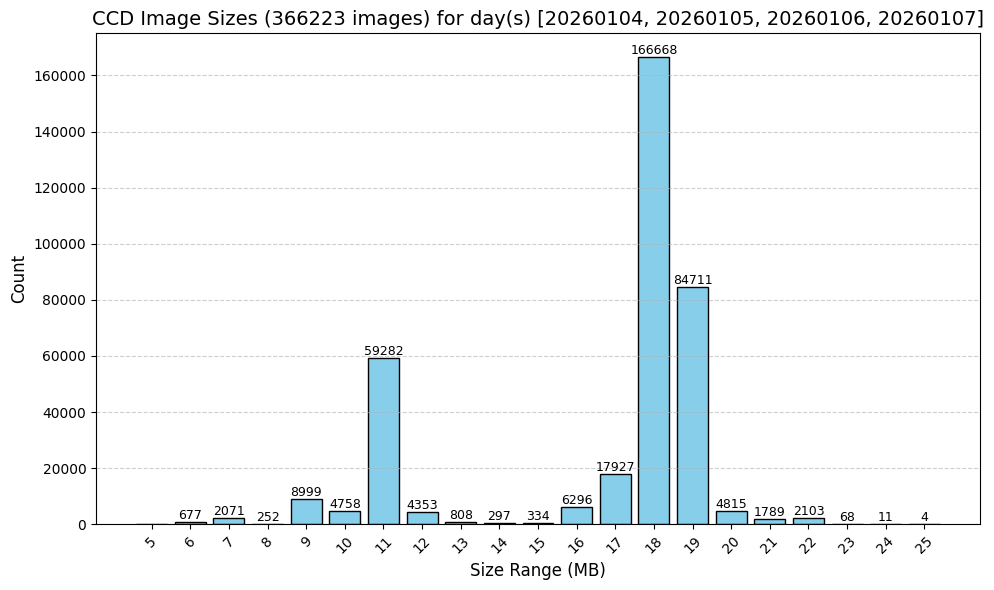

In [48]:
import numpy as np
import matplotlib.pyplot as plt


bins =  list(range(5, 27))
# Compute histogram
hist, edges = np.histogram(sizes, bins=bins)

# Create bin labels int
bin_labels = [f"{int(edges[i])}" for i in range(len(edges)-1)]
# Plot histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(bin_labels, hist, width=0.8, edgecolor='black', color='skyblue')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(height),
                 ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xlabel("Size Range (MB)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"CCD Image Sizes ({len(sizes)} images) for day(s) {days}", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [42]:
from sklearn.mixture import GaussianMixture

# Reshape for sklearn
X = sizes.reshape(-1, 1)

# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)

# Extract means
means = gmm.means_.flatten()
# Sort for readability
means = np.sort(means)

print("Estimated means:", means)

Estimated means: [11.02459026 18.78916336]
